# Recurrent Neural Networks 

In [ ]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell, MaxPooling2D, Rescaling, BatchNormalization, MaxPooling3D, LeakyReLU
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose, Input

# Dataset

In order to create image queries of simple arithmetic operations such as '51+31' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset.

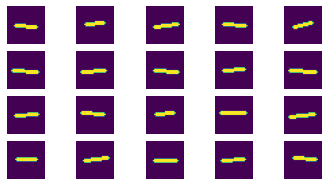

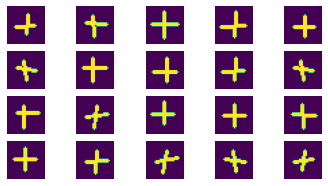

In [ ]:
# Create plus/minus signs
def generate_images(cross=False, n=50):
    x = np.random.randint(12, 16, (n, 2))
    y1 = np.random.randint(4, 8, n)
    y2 = np.random.randint(20, 24, n)
    
    blank = np.zeros([n, 28, 28])
    for i in range(n):
        line = cv2.line(blank[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)
        if cross:
            line = cv2.line(blank[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank

def show_generated(images):
    for i in range(20):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(cross=True))

In [ ]:
def create_data(highest_integer, padding_whole=False):
    """
    Creates the following data for all pairs of integers up to [highest integer]+[highest_integer]:

    @return:
    X_text: '151+ 21' -> text query of an arithmetic operation
    X_img : Stack of MNIST images corresponding to the query (7 x 28 x 28)
    y_text: ' 172' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (4 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(cross=True)
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []
    for i in range(highest_integer + 1):
        for j in range(highest_integer + 1):
            
            for sign in ['-', '+']:

                if padding_whole:

                    i_char = str(i)
                    j_char = str(j)    
                    query_string = add_padding(i_char + sign + j_char, max_len=max_query_length, padding="left") 

                else:

                    i_char = add_padding(str(i), max_len=max_int_length, padding="left")
                    j_char = add_padding(str(j), max_len=max_int_length, padding="left")  
                    query_string = i_char + sign + j_char

                query_image = []

                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = add_padding(str(result), max_len=max_answer_length, padding="left")
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))
            
    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.
  

def add_padding(item, max_len=3, padding="left"):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(item)
    padding_string = (max_len - length) * ' '

    if padding == "left":
        return item + padding_string
    elif padding == "right":
        return padding_string + item

# Creating our data

The dataset consists of 80000 samples that have two kinds of inputs and labels:

  X_text: strings containing queries of length 7: ['  1+  1', '174- 18', ...] 

  X_image: a stack of images representing a single query, dimensions: [7, 28, 28]

  y_text: strings containing answers of length 4: ['   2', ' 156']

  y_image: a stack of images that represents the answer to a query, dimensions: [4, 28, 28]

11501568/11490434 [==============================] - 0s 0us/step
(80000,) (80000, 7, 28, 28) (80000,) (80000, 4, 28, 28)
Sample ID: 6082

X_text: "15 -41 " = y_text: "-26 "


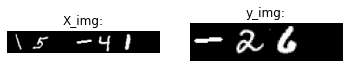

Sample ID: 46797

X_text: "116+198" = y_text: "314 "


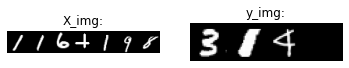

Sample ID: 42508

X_text: "106-54 " = y_text: "52  "


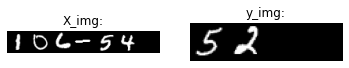

Sample ID: 2977

X_text: "7  +88 " = y_text: "95  "


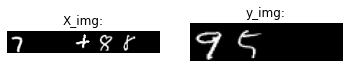

Sample ID: 32359

X_text: "80 +179" = y_text: "259 "


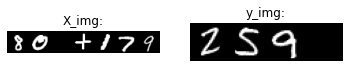

Sample ID: 47815

X_text: "119+107" = y_text: "226 "


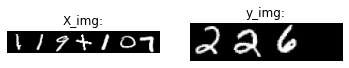

Sample ID: 28598

X_text: "71 -99 " = y_text: "-28 "


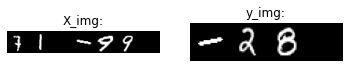

Sample ID: 59746

X_text: "149-73 " = y_text: "76  "


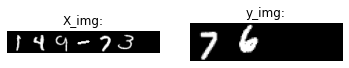

Sample ID: 61538

X_text: "153-169" = y_text: "-16 "


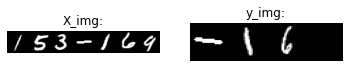

Sample ID: 41428

X_text: "103-114" = y_text: "-11 "


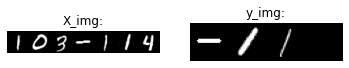

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- ' # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 199 # Highest value of integers contained in the queries
max_int_length = len(str(highest_integer)) # 
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = max_int_length + 1    # Maximum length of the answer string

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labs = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        plt.axis('off')
        plt.title(labs[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nSample ID: {n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 80000, 1)[0])

In [ ]:
def encode_labels(labels, max_len=4):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot 

def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])
    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)
print(X_text_onehot[0])
print(y_text_onehot[0])
a = [[1 ,2 ,3, 4, 5, 6, 7, 8, 1, 10, 11, 12, 13], [1 ,21 ,3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]]
np.argmax(a, axis=1)
# encode_labels(decode_labels(a))
xxx = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,]]

decode_labels(xxx)

(80000, 7, 13) (80000, 4, 13)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


'   0'

---
---
# 1. Text-to-text RNN model

The following code showcases how Recurrent neural networks are built using Keras. Several new layers are going to be used:

1. LSTM 
2. TimeDistributed
3. RepeatVector

The following code shows the basic architecture of a Recurrent Neural Network
LSTM (Long Short Term Memory) layers can be replaced either with SimpleRNN or GRU (Gated Recurrent Units).



<img src="https://miro.medium.com/max/1400/1*1JcHGUU7rFgtXC_mydUA_Q.jpeg" width="500"> 


In [ ]:
def text2text_model():
  text2text = tf.keras.Sequential()

  text2text.add(LSTM(256, input_shape=(max_query_length, len(unique_characters))))
  text2text.add(RepeatVector(max_answer_length))
  text2text.add(LSTM(128, return_sequences=True))
  text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

  text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  text2text.summary()
  return text2text

#### 1. Different ratios of train/test splits

In [ ]:
TEST_SET_RATIO_RANGE = np.arange(0.05, 1, 0.05)

train_report_per_test_set_ratio = {}
test_report_per_test_set_ratio = {}

for test_set_ratio in TEST_SET_RATIO_RANGE:
  X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text_onehot, y_text_onehot, test_size=test_set_ratio, random_state=42)
  model = text2text_model()
  model.fit(
    X_text_train,
    y_text_train,
    epochs=20,
    batch_size=128,
  )

  y_pred_decoded = [decode_labels(item) for item in model.predict(X_text_test)]
  y_test_decoded = [decode_labels(item) for item in y_text_test]

  y_train_pred_decoded = [decode_labels(item) for item in model.predict(X_text_train)]
  y_train_decoded = [decode_labels(item) for item in y_text_train]

  test_report_per_test_set_ratio[test_set_ratio] = classification_report(
      y_test_decoded, y_pred_decoded, output_dict=True, zero_division=0
      )["weighted avg"]
  train_report_per_test_set_ratio[test_set_ratio] = classification_report(
    y_train_decoded, y_train_pred_decoded, output_dict=True, zero_division=0
    )["weighted avg"]

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_76 (LSTM)              (None, 256)               276480    
                                                                 
 repeat_vector_38 (RepeatVec  (None, 4, 256)           0         
 tor)                                                            
                                                                 
 lstm_77 (LSTM)              (None, 4, 128)            197120    
                                                                 
 time_distributed_38 (TimeDi  (None, 4, 13)            1677      
 stributed)                                                      
                                                                 
Total params: 475,277
Trainable params: 475,277
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
594/594 [===========================

In [ ]:
train_report_per_test_set_ratio_df = pd.DataFrame.from_dict(train_report_per_test_set_ratio).transpose().reset_index()

train_report_per_test_set_ratio_df

,index,precision,recall,f1-score,support
0,0.05,0.984297,0.982645,0.982746,76000.0
1,0.10,0.978167,0.975167,0.975013,72000.0
2,0.15,0.953106,0.948587,0.948663,67999.0
3,0.20,0.980450,0.977734,0.977875,64000.0
4,0.25,0.967965,0.964233,0.964443,60000.0
5,0.30,0.958463,0.954393,0.955162,56000.0
6,0.35,0.892115,0.883767,0.883679,51999.0
7,0.40,0.931067,0.924396,0.923879,48000.0
8,0.45,0.931227,0.923159,0.923691,44000.0
9,0.50,0.812894,0.797025,0.797314,40000.0


In [ ]:
test_report_per_test_set_ratio_df = pd.DataFrame.from_dict(test_report_per_test_set_ratio).transpose().reset_index()

test_report_per_test_set_ratio_df

,index,precision,recall,f1-score,support
0,0.05,0.982288,0.978750,0.979050,4000.0
1,0.10,0.968786,0.963250,0.962752,8000.0
2,0.15,0.950731,0.943005,0.942530,12001.0
3,0.20,0.975043,0.970187,0.970536,16000.0
4,0.25,0.961084,0.955500,0.955650,20000.0
5,0.30,0.947727,0.941542,0.942272,24000.0
6,0.35,0.878978,0.869755,0.869231,28001.0
7,0.40,0.914549,0.908250,0.907797,32000.0
8,0.45,0.910443,0.899278,0.900195,36000.0
9,0.50,0.781085,0.762825,0.763284,40000.0


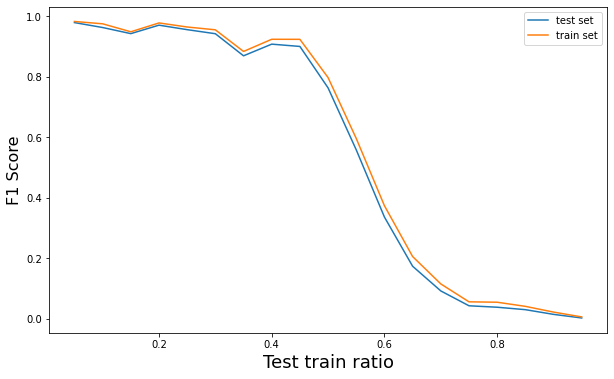

In [ ]:
test_ratios = list(test_report_per_test_set_ratio.keys())
test_f1_scores = list(report['f1-score'] for report in test_report_per_test_set_ratio.values())
train_f1_scores = list(report['f1-score'] for report in train_report_per_test_set_ratio.values())

fig = plt.figure(figsize=(10, 6))

plt.plot(test_report_per_test_set_ratio_df["index"], test_report_per_test_set_ratio_df["f1-score"], label='test set')
plt.plot(train_report_per_test_set_ratio_df["index"], train_report_per_test_set_ratio_df["f1-score"], label='train set')

plt.xlabel('Test train ratio', fontsize=18)
plt.ylabel('F1 Score', fontsize=16)
plt.legend()

fig.savefig('text2text_splits.jpg')

plt.show()


#### 2. Finding more optimal architectures

##### Changing parameters of given text2text model

In [ ]:
def custom_lstm_model_2_layers(lstm_neurons_1, lstm_neurons_2, dropout=0):
  text2text = tf.keras.Sequential()

  text2text.add(LSTM(lstm_neurons_1, input_shape=(max_query_length, len(unique_characters)), dropout=dropout))
  text2text.add(RepeatVector(max_answer_length))
  text2text.add(LSTM(lstm_neurons_2, return_sequences=True))
  text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

  text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  text2text.summary()
  return text2text

def custom_lstm_model_3_layers(lstm_neurons_1, lstm_neurons_2, lstm_neurons_3, dropout=0):
  text2text = tf.keras.Sequential()

  text2text.add(LSTM(lstm_neurons_1, input_shape=(max_query_length, len(unique_characters)), dropout=dropout))
  text2text.add(RepeatVector(max_answer_length))

  text2text.add(LSTM(lstm_neurons_2, dropout=dropout))
  text2text.add(RepeatVector(max_answer_length))

  text2text.add(LSTM(lstm_neurons_3, return_sequences=True))
  text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

  text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  text2text.summary()
  return text2text


def custom_gru_model_2_layers(gru_neurons_1, gru_neurons_2, dropout=0):
  text2text = tf.keras.Sequential()

  text2text.add(GRU(gru_neurons_1, input_shape=(max_query_length, len(unique_characters)), dropout=dropout))
  text2text.add(RepeatVector(max_answer_length))
  text2text.add(GRU(gru_neurons_2, return_sequences=True))
  text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

  text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  text2text.summary()
  return text2text


def custom_rnn_model_2_layers(rnn_neurons_1, rnn_neurons_2, dropout=0):
  text2text = tf.keras.Sequential()

  text2text.add(SimpleRNN(rnn_neurons_1, input_shape=(max_query_length, len(unique_characters)), dropout=dropout))
  text2text.add(RepeatVector(max_answer_length))
  text2text.add(SimpleRNN(rnn_neurons_2, return_sequences=True))
  text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

  text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  text2text.summary()
  return text2text

  

In [ ]:
OPTIMIZED_MODELS = {
    'baseline(lstm-256-128)': text2text_model(),
    'lstm-512-256': custom_lstm_model_2_layers(512, 256),
    'gru-256-128': custom_gru_model_2_layers(256, 128),
    'gru-512-256': custom_gru_model_2_layers(512, 256),
    'rnn-256-128': custom_rnn_model_2_layers(256, 128),
    'rnn-512-256': custom_rnn_model_2_layers(512, 256),
}

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               276480    
                                                                 
 repeat_vector (RepeatVector  (None, 4, 256)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 4, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 4, 13)            1677      
 ibuted)                                                         
                                                                 
Total params: 475,277
Trainable params: 475,277
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
____________________________

In [ ]:
EPOCHS = 20
TEST_SET_RATIO = 0.2

np.random.seed(42)
tf.random.set_seed(42)

X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
      X_text_onehot, y_text_onehot, test_size=TEST_SET_RATIO, random_state=41
    )

test_reports = {}
train_reports = {}

for model_name in OPTIMIZED_MODELS:

  print(f'Training model {model_name}')

  model = OPTIMIZED_MODELS[model_name]
  model_train_report = {}
  model_test_report = {}

  for epoch in range(1, EPOCHS+1):
    model.fit(
      X_text_train,
      y_text_train,
      epochs=1,
      batch_size=128,
    )

    y_pred_decoded = [decode_labels(item) for item in model.predict(X_text_test)]
    y_test_decoded = [decode_labels(item) for item in y_text_test]

    y_train_pred_decoded = [decode_labels(item) for item in model.predict(X_text_train)]
    y_train_decoded = [decode_labels(item) for item in y_text_train]

    model_test_report[epoch] = classification_report(
      y_test_decoded, y_pred_decoded, output_dict=True, zero_division=0
      )["weighted avg"]
    model_train_report[epoch] = classification_report(
      y_train_decoded, y_train_pred_decoded, output_dict=True, zero_division=0
      )["weighted avg"]

  print(f'Results from {model_name} in train set: ')
  print(model_train_report[20])
    
  print(f'Results from {model_name} in test set: ')
  print(model_test_report[20])

  test_reports[model_name] = model_test_report
  train_reports[model_name] = model_train_report



Training model baseline(lstm-256-128)
500/500 [==============================] - 3s 5ms/step - loss: 0.0420 - accuracy: 0.9903
Results from baseline(lstm-256-128) in train set: 
{'precision': 0.9644919134056876, 'recall': 0.962609375, 'f1-score': 0.9628317712393456, 'support': 64000}
Results from baseline(lstm-256-128) in test set: 
{'precision': 0.9654325032873454, 'recall': 0.9635625, 'f1-score': 0.9633977634910674, 'support': 16000}
Training model lstm-512-256
500/500 [==============================] - 3s 6ms/step - loss: 0.0298 - accuracy: 0.9914
Results from lstm-512-256 in train set: 
{'precision': 0.9996391165899238, 'recall': 0.99965625, 'f1-score': 0.9996396320107612, 'support': 64000}
Results from lstm-512-256 in test set: 
{'precision': 0.9994741567460317, 'recall': 0.9994375, 'f1-score': 0.9994311126974312, 'support': 16000}
Training model gru-256-128
500/500 [==============================] - 2s 5ms/step - loss: 0.0535 - accuracy: 0.9852
Results from gru-256-128 in train s

In [ ]:
print(test_reports['gru-512-256'])

{1: {'precision': 0.003786591968374652, 'recall': 0.0269375, 'f1-score': 0.004920251547229065, 'support': 16000}, 2: {'precision': 0.014874555419453253, 'recall': 0.04575, 'f1-score': 0.015403630416601078, 'support': 16000}, 3: {'precision': 0.01940530807133924, 'recall': 0.0493125, 'f1-score': 0.02003300717502132, 'support': 16000}, 4: {'precision': 0.030790514972762858, 'recall': 0.064125, 'f1-score': 0.029083490943778476, 'support': 16000}, 5: {'precision': 0.05336825846924011, 'recall': 0.0834375, 'f1-score': 0.043818833946517005, 'support': 16000}, 6: {'precision': 0.22772705340286953, 'recall': 0.2314375, 'f1-score': 0.19046127609239388, 'support': 16000}, 7: {'precision': 0.867520899195597, 'recall': 0.8525625, 'f1-score': 0.8485736419301299, 'support': 16000}, 8: {'precision': 0.8985861196540904, 'recall': 0.890375, 'f1-score': 0.8877683634029766, 'support': 16000}, 9: {'precision': 0.874460416060871, 'recall': 0.8566875, 'f1-score': 0.8546939432799907, 'support': 16000}, 10: {

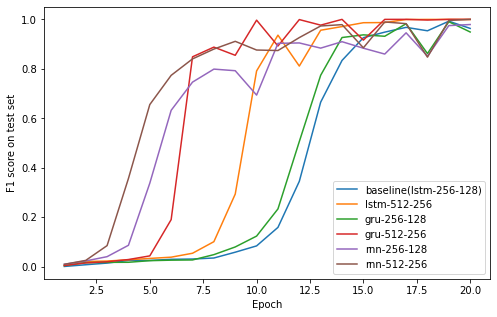

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

models = list(test_reports.keys())
for model_name in OPTIMIZED_MODELS:
  epochs = list(test_reports[model_name].keys())
  f1_scores_test = list(report['f1-score'] for report in test_reports[model_name].values())
  # f1_scores_train = list(report['f1-score'] for report in train_reports[model_name].values())
  ax.plot(epochs, f1_scores_test, label=model_name)
  # plt.plot(epochs, f1_scores_train, label=model_name+' on train')

ax.set_xlabel('Epoch')
ax.set_ylabel('F1 score on test set')
ax.legend()
plt.show()
fig.savefig('text2text_optimized.jpg')
  

##### Change padding of input text

(80000,) (80000, 7, 28, 28) (80000,) (80000, 4, 28, 28)
Sample ID: 19337

X_text: "48+68  " = y_text: "116 "


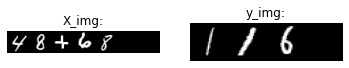

Sample ID: 45989

X_text: "114+194" = y_text: "308 "


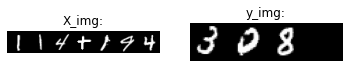

Sample ID: 15406

X_text: "38-103 " = y_text: "-65 "


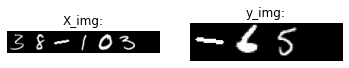

Sample ID: 10266

X_text: "25-133 " = y_text: "-108"


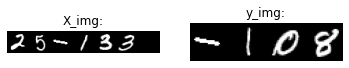

Sample ID: 22258

X_text: "55-129 " = y_text: "-74 "


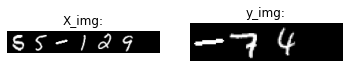

Sample ID: 24469

X_text: "61+34  " = y_text: "95  "


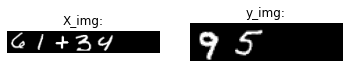

Sample ID: 55704

X_text: "139-52 " = y_text: "87  "


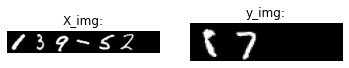

Sample ID: 59020

X_text: "147-110" = y_text: "37  "


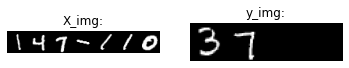

Sample ID: 72836

X_text: "182-18 " = y_text: "164 "


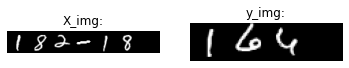

Sample ID: 63826

X_text: "159-113" = y_text: "46  "


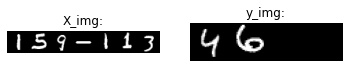

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- ' # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 199 # Highest value of integers contained in the queries
max_int_length = len(str(highest_integer)) # 
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = max_int_length + 1    # Maximum length of the answer string

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer, True)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labs = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        plt.axis('off')
        plt.title(labs[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nSample ID: {n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 80000, 1)[0])

In [ ]:
X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(80000, 7, 13) (80000, 4, 13)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, y_text_onehot, test_size=0.3, random_state=42)

batch_size = 64
epochs = 20

text2text = text2text_model()

history = text2text.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

2021-12-16 23:47:16.080695: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               276480    
                                                                 
 repeat_vector (RepeatVector  (None, 4, 256)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 4, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 4, 13)            1677      
 ibuted)                                                         
                                                                 
Total params: 475,277
Trainable params: 475,277
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
875/875 [==============================

In [ ]:
y_pred_decoded = [decode_labels(item) for item in text2text.predict(X_test)]
y_test_decoded = [decode_labels(item) for item in y_test]

classification_report_metrics = classification_report(y_test_decoded, y_pred_decoded, output_dict=True, zero_division=0)

print(classification_report_metrics["accuracy"])
print(classification_report_metrics["weighted avg"])

0.95825
{'precision': 0.9614983023258598, 'recall': 0.95825, 'f1-score': 0.9585936799495579, 'support': 24000}



---
---

# 2. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use X_img as inputs and y_text as outputs.

In [ ]:
IMAGE_PIXELS = 28
INPUT_SHAPE=(max_query_length, IMAGE_PIXELS, IMAGE_PIXELS, 1)
IMAGE_SHAPE = (IMAGE_PIXELS, IMAGE_PIXELS, 1)
X_img_train, X_img_test, y_text_train, y_text_test = train_test_split(
    X_img, y_text_onehot, test_size=0.2, random_state=42
  )


In [ ]:
X_img_train.shape

## Model using LSTM

In [ ]:
def img2text_with_lstm():
  '''
  flatten given images and pass them through LSTMs as a sequence
  '''
  img2text = tf.keras.Sequential()
  img2text.add(Reshape(
      (max_query_length, IMAGE_PIXELS * IMAGE_PIXELS), 
      input_shape=INPUT_SHAPE
      ))
  img2text.add(LSTM(1024, dropout=0.35))
  img2text.add(RepeatVector(max_answer_length))
  img2text.add(LSTM(1024, dropout=0.35))
  img2text.add(RepeatVector(max_answer_length))
  img2text.add(LSTM(512, return_sequences=True))
  img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

  img2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  img2text.summary()
  return img2text

In [ ]:
EPOCHS = 30

img2text_lstm_model = img2text_with_lstm()
test_report_per_epoch = {}
train_report_per_epoch = {}

img2text_lstm_model.fit(
  X_img_train,
  y_text_train,
  epochs=EPOCHS,
  batch_size=128,
)

y_pred_decoded = [decode_labels(item) for item in img2text_lstm_model.predict(X_img_test)]
y_test_decoded = [decode_labels(item) for item in y_text_test]

y_train_pred_decoded = [decode_labels(item) for item in img2text_lstm_model.predict(X_img_train)]
y_train_decoded = [decode_labels(item) for item in y_text_train]

img2text_lstm_model_test_report = classification_report(
    y_test_decoded, y_pred_decoded, output_dict=True, zero_division=0
    )["weighted avg"]
img2text_lstm_model_train_report = classification_report(
    y_train_decoded, y_train_pred_decoded, output_dict=True, zero_division=0
    )["weighted avg"]

print(img2text_lstm_model_test_report)
print(img2text_lstm_model_train_report)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 7, 784)            0         
                                                                 
 lstm_4 (LSTM)               (None, 1024)              7409664   
                                                                 
 repeat_vector_6 (RepeatVect  (None, 4, 1024)          0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 1024)              8392704   
                                                                 
 repeat_vector_7 (RepeatVect  (None, 4, 1024)          0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 4, 512)           

In [ ]:
print(f'Train set evaluation: {img2text_lstm_model_train_report}')
print(f'Test set evaluation: {img2text_lstm_model_test_report}')

Train set evaluation: {'precision': 0.9863284416443856, 'recall': 0.986046875, 'f1-score': 0.9861127005506758, 'support': 64000}
Test set evaluation: {'precision': 0.9408707764884016, 'recall': 0.93775, 'f1-score': 0.9381366678347337, 'support': 16000}


## Model using CNN and then LSTMs

In [ ]:

def cnn(input_shape):
  cnn = tf.keras.Sequential()
  cnn.add(Conv2D(
      filters=64, 
      kernel_size=5, 
      activation='leaky_relu', 
      kernel_initializer='he_normal', 
      padding="SAME", 
      input_shape=input_shape
      ))
  
  cnn.add(MaxPooling2D(pool_size=2))

  cnn.add(Conv2D(
      filters=32, 
      kernel_size=3, 
      activation='leaky_relu', 
      kernel_initializer='he_normal', 
      padding="SAME"
      ))
  
  cnn.add(MaxPooling2D(pool_size=2))
  
  cnn.add(Flatten())
  
  return cnn

def img2text_with_image_convolutions_and_lstm():
  '''
  Pass the given images through a CNN and then 
  pass the convoluted images flattened to LSTM as a sequence
  '''
  img2text = tf.keras.Sequential()

  img2text.add(TimeDistributed(cnn(IMAGE_SHAPE), input_shape=INPUT_SHAPE))
  img2text.add(LSTM(512, dropout=0.3))
  img2text.add(RepeatVector(max_answer_length))
  img2text.add(LSTM(512, dropout=0.3))
  img2text.add(RepeatVector(max_answer_length))
  img2text.add(LSTM(256, return_sequences=True))
  img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
  img2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  img2text.summary()

  return img2text

# 256 256 128 -> 91.2 97 in 40 epochs
# 512-D0.3 512-D0.3 256 -> 98 99 in 30 epochs, 98.6 99.6 in 40 epochs


In [ ]:
img2text_cnn_lstm_model = img2text_with_image_convolutions_and_lstm()

img2text_cnn_lstm_model.fit(
  X_img_train,
  y_text_train,
  epochs=30,
  batch_size=128,
)

y_pred_decoded = [decode_labels(item) for item in img2text_cnn_lstm_model.predict(X_img_test)]
y_test_decoded = [decode_labels(item) for item in y_text_test]

y_train_pred_decoded = [decode_labels(item) for item in img2text_cnn_lstm_model.predict(X_img_train)]
y_train_decoded = [decode_labels(item) for item in y_text_train]

img2text_cnn_lstm_model_test_report = classification_report(
    y_test_decoded, y_pred_decoded, output_dict=True, zero_division=0
    )["weighted avg"]
img2text_cnn_lstm_model_train_report = classification_report(
    y_train_decoded, y_train_pred_decoded, output_dict=True, zero_division=0
    )["weighted avg"]

print(img2text_cnn_lstm_model_test_report)
print(img2text_cnn_lstm_model_train_report)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 7, 1568)          20128     
 tributed)                                                       
                                                                 
 lstm_10 (LSTM)              (None, 512)               4261888   
                                                                 
 repeat_vector_10 (RepeatVec  (None, 4, 512)           0         
 tor)                                                            
                                                                 
 lstm_11 (LSTM)              (None, 512)               2099200   
                                                                 
 repeat_vector_11 (RepeatVec  (None, 4, 512)           0         
 tor)                                                            
                                                      

In [ ]:
print(f'Train set evaluation: {img2text_cnn_lstm_model_train_report}')
print(f'Test set evaluation: {img2text_cnn_lstm_model_test_report}')

Train set evaluation: {'precision': 0.9898036775665571, 'recall': 0.989125, 'f1-score': 0.9893863853029354, 'support': 64000}
Test set evaluation: {'precision': 0.9751920138207919, 'recall': 0.9731875, 'f1-score': 0.9735852185143584, 'support': 16000}


# 3. Text to image RNN Model

The goal here is to use X_text as inputs and y_img as outputs.

## SSIM loss for comparing images

In [ ]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

## Define sub models

In [ ]:
def get_text2img_model():

  text2img = tf.keras.Sequential(name="text2img")

  # Input
  # foundation for 7*7 image
  text2img.add(Input(shape=(4, 13)))
  text2img.add(Flatten())

  n_nodes = 128 * 7 * 7
  text2img.add(Dense(n_nodes, input_dim=52, name="dense_input"))

  text2img.add(LeakyReLU(alpha=0.2))
  text2img.add(Reshape((7, 7, 128), name="reshape"))

  # upsample to 14x14
  text2img.add(Conv2DTranspose(128, (4,4), strides=(2,4), padding='same', name="conv_2d_transpose_1"))
  text2img.add(LeakyReLU(alpha=0.2))

  # upsample to 28x28
  text2img.add(Conv2DTranspose(128, (4,4), strides=(2,4), padding='same', name="conv_2d_transpose_2"))
  text2img.add(LeakyReLU(alpha=0.2))
  text2img.add(Conv2D(1, (7,7), activation='sigmoid', padding='same', name="conv_2d"))

  text2img.compile(loss=SSIMLoss, optimizer="adam", metrics=["mse"])

  return text2img


def get_text2text_model(X, max_answer_length):
  # We start by initializing a sequential model
  text2text = tf.keras.Sequential(name="text2text")

  # "Encode" the input sequence using an RNN, producing an output of size 256.
  # In this case the size of our input vectors is [7, 13] as we have queries of length 7 and 13 unique characters. Each of these 7 elements in the query will be fed to the network one by one,
  # as shown in the image above (except with 7 elements).
  # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
  text2text.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))

  # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 4 times as that's the maximum length of the output (e.g. '  1-199' = '-198')
  # when using 3-digit integers in queries. In other words, the RNN will always produce 4 characters as its output.
  text2text.add(RepeatVector(max_answer_length))

  # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
  # the first dimension to be the timesteps.
  text2text.add(LSTM(128, return_sequences=True))

  # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
  text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

  text2text.compile(loss="CategoricalCrossentropy", metrics="accuracy")

  return text2text

In [ ]:
text2text = get_text2text_model(X_text_onehot, max_answer_length)

text2text.summary()

Model: "text2text"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 256)               276480    
                                                                 
 repeat_vector_4 (RepeatVect  (None, 4, 256)           0         
 or)                                                             
                                                                 
 lstm_9 (LSTM)               (None, 4, 128)            197120    
                                                                 
 time_distributed_4 (TimeDis  (None, 4, 13)            1677      
 tributed)                                                       
                                                                 
Total params: 475,277
Trainable params: 475,277
Non-trainable params: 0
_________________________________________________________________


In [ ]:
text2img = get_text2img_model()

text2img.summary()

Model: "text2img"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 52)                0         
                                                                 
 dense_input (Dense)         (None, 6272)              332416    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv_2d_transpose_1 (Conv2D  (None, 14, 28, 128)      262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 14, 28, 128)       0         
                                                          

## Train text2text

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, y_text_onehot, test_size=0.15, random_state=42)

batch_size = 64
epochs = 20

text2text = get_text2text_model(X_text_onehot, max_answer_length)

history = text2text.fit(X_train, y_train, batch_size=batch_size, validation_split=0.2, epochs=epochs)

Epoch 1/20
850/850 [==============================] - 9s 8ms/step - loss: 1.3892 - accuracy: 0.4579 - val_loss: 1.2240 - val_accuracy: 0.5183
Epoch 2/20
850/850 [==============================] - 6s 7ms/step - loss: 1.1241 - accuracy: 0.5632 - val_loss: 0.9935 - val_accuracy: 0.6232
Epoch 3/20
850/850 [==============================] - 6s 7ms/step - loss: 0.9631 - accuracy: 0.6181 - val_loss: 0.9175 - val_accuracy: 0.6311
Epoch 4/20
850/850 [==============================] - 6s 7ms/step - loss: 0.8770 - accuracy: 0.6522 - val_loss: 0.8086 - val_accuracy: 0.6944
Epoch 5/20
850/850 [==============================] - 6s 7ms/step - loss: 0.8273 - accuracy: 0.6735 - val_loss: 0.8532 - val_accuracy: 0.6464
Epoch 6/20
850/850 [==============================] - 6s 7ms/step - loss: 0.7910 - accuracy: 0.6898 - val_loss: 0.7745 - val_accuracy: 0.6948
Epoch 7/20
850/850 [==============================] - 6s 7ms/step - loss: 0.7472 - accuracy: 0.7106 - val_loss: 0.6834 - val_accuracy: 0.7412
Epoch 

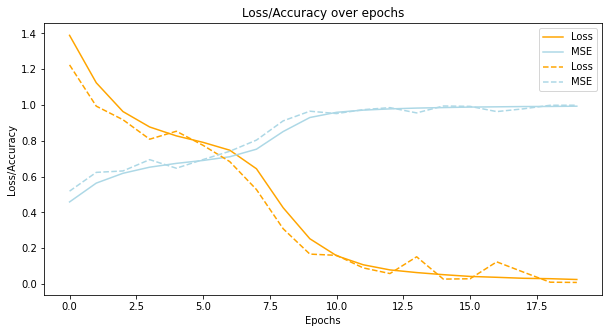

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(np.arange(len(history.history["loss"])), history.history["loss"], color="orange", label="Loss")
plt.plot(np.arange(len(history.history["accuracy"])), history.history["accuracy"], color="lightblue", label="MSE")

plt.plot(np.arange(len(history.history["val_loss"])), history.history["val_loss"], color="orange", linestyle="dashed", label="Loss")
plt.plot(np.arange(len(history.history["val_accuracy"])), history.history["val_accuracy"], color="lightblue", linestyle="dashed", label="MSE")

plt.title("Loss/Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")

plt.legend()

plt.show()

In [ ]:
y_pred_decoded = [decode_labels(item) for item in text2text.predict(X_test)]
y_test_decoded = [decode_labels(item) for item in y_test]

classification_report_metrics = classification_report(y_test_decoded, y_pred_decoded, output_dict=True, zero_division=0)

print(classification_report_metrics["accuracy"])
print(classification_report_metrics["weighted avg"])

0.9945
{'precision': 0.994929453526847, 'recall': 0.9945, 'f1-score': 0.9945059947112771, 'support': 12000}


## Train text2img

In [ ]:
indexes = np.random.choice(y_text_onehot.shape[0], 10000, replace=False)

X = y_text_onehot[indexes]
y = np.array([np.concatenate((y), axis=1) for y in y_img[indexes]])

print(X.shape)
print(y.shape)

(10000, 4, 13)
(10000, 28, 112)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

batch_size = 64
epochs = 10

text2img = get_text2img_model()

history = text2img.fit(X_train, y_train, batch_size=batch_size, validation_split=0.2, epochs=epochs)

Epoch 1/10
107/107 [==============================] - 5s 33ms/step - loss: 0.5279 - mse: 0.0849 - val_loss: 0.3668 - val_mse: 0.0489
Epoch 2/10
107/107 [==============================] - 3s 29ms/step - loss: 0.3551 - mse: 0.0432 - val_loss: 0.3585 - val_mse: 0.0435
Epoch 3/10
107/107 [==============================] - 3s 29ms/step - loss: 0.3524 - mse: 0.0420 - val_loss: 0.3576 - val_mse: 0.0423
Epoch 4/10
107/107 [==============================] - 3s 29ms/step - loss: 0.3506 - mse: 0.0416 - val_loss: 0.3559 - val_mse: 0.0429
Epoch 5/10
107/107 [==============================] - 3s 29ms/step - loss: 0.3483 - mse: 0.0414 - val_loss: 0.3560 - val_mse: 0.0415
Epoch 6/10
107/107 [==============================] - 3s 29ms/step - loss: 0.3470 - mse: 0.0411 - val_loss: 0.3555 - val_mse: 0.0410
Epoch 7/10
107/107 [==============================] - 3s 29ms/step - loss: 0.3471 - mse: 0.0411 - val_loss: 0.3557 - val_mse: 0.0409
Epoch 8/10
107/107 [==============================] - 3s 29ms/step - 

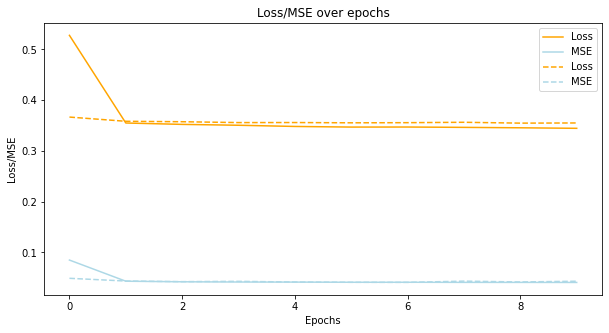

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(np.arange(len(history.history["loss"])), history.history["loss"], color="orange", label="Loss")
plt.plot(np.arange(len(history.history["mse"])), history.history["mse"], color="lightblue", label="MSE")

plt.plot(np.arange(len(history.history["val_loss"])), history.history["val_loss"], color="orange", linestyle="dashed", label="Loss")
plt.plot(np.arange(len(history.history["val_mse"])), history.history["val_mse"], color="lightblue", linestyle="dashed", label="MSE")

plt.title("Loss/MSE over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss/MSE")

plt.legend()

plt.show()

In [ ]:
y_pred = text2img.predict(X_test)
y_pred = y_pred.reshape(-1, 28, 112)

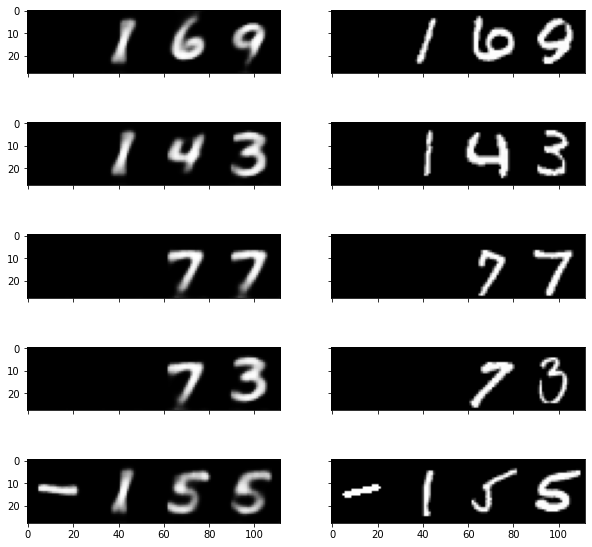

In [ ]:
offset = 0
n = 5

fig, ax = plt.subplots(n, 2, figsize=(10, 10), sharex=True, sharey=True)

for index in range(n):

    ax[index, 0].imshow(y_pred[index + offset], cmap="gray")
    ax[index, 1].imshow(y_test[index + offset], cmap="gray")

plt.show()

## Final model using pretrained text2text and text2img models

In [ ]:
final_model = tf.keras.Sequential()

final_model.add(text2text)

final_model.add(text2img)

final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text2text (Sequential)      (None, 4, 13)             475277    
                                                                 
 text2img (Sequential)       (None, 28, 112, 1)        863233    
                                                                 
Total params: 1,338,510
Trainable params: 1,338,510
Non-trainable params: 0
_________________________________________________________________


In [ ]:
indexes = np.random.choice(y_text_onehot.shape[0], 1000, replace=False)

y_pred = final_model(X_text_onehot[indexes])
y_pred = y_pred.numpy().reshape(-1, 28, 112)

y_test = np.array([np.concatenate((y), axis=1) for y in y_img[indexes]])

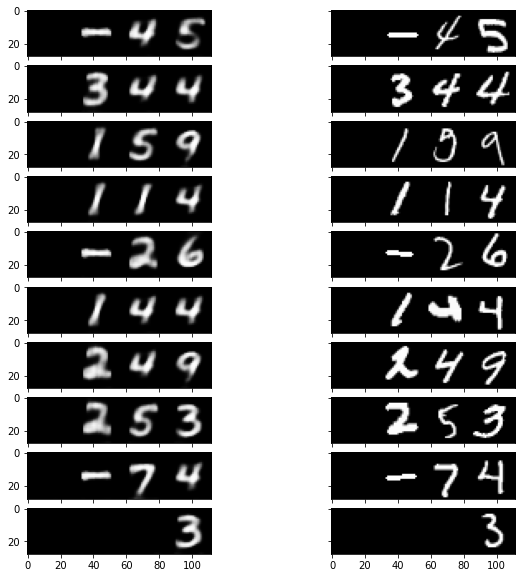

In [ ]:
offset = 0
n = 10

fig, ax = plt.subplots(n, 2, figsize=(10, 10), sharex=True, sharey=True)

for index in range(n):

    ax[index, 0].imshow(y_pred[index + offset], cmap="gray")
    ax[index, 1].imshow(y_test[index + offset], cmap="gray")

plt.show()